In [ ]:
!pip install jsonlines
!pip install matplotlib
!pip install adjustText

**Cella per caricare i file di training e test di ABSITA 2020**

In [ ]:
from google.colab import files

#caricamento del file di absita
uploaded = files.upload()
uploaded = files.upload()

Saving ate_absita_training_anon.ndjson to ate_absita_training_anon.ndjson


Saving ate_absita_dev.ndjson to ate_absita_dev.ndjson


**Caricamento del modello e del tokenizer associato**

In [ ]:
import jsonlines

from transformers import AutoTokenizer, BertForTokenClassification, AdamW


#caricamento del modello pre-addestrato

model_id = "dbmdz/bert-base-italian-cased"  #modello BERT italiano

model = BertForTokenClassification.from_pretrained(model_id, num_labels=7) #aggiunta testa classificazione


#caricamento tokenizer associato al modello BERT
tokenizer = AutoTokenizer.from_pretrained(model_id)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/433 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/442M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at dbmdz/bert-base-italian-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/59.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/235k [00:00<?, ?B/s]

**Definizione di funzioni per la tokenizzazione e mappatura da caratteri a token**

In [ ]:
#funzione per tokenizzare frasi utilizzando il tokenizer associato al modello BERT
def tokenize_sentence(sentence):
    return tokenizer(sentence, truncation=True, padding="max_length", max_length=64)

#funzione per mappare le posizioni dei caratteri nei token corrispondenti
def map_char_positions_to_token_positions(sentence, char_positions, tokenizer):

    tokens = tokenizer.tokenize(sentence)
    token_offsets = tokenizer(sentence, return_offsets_mapping=True)["offset_mapping"]

    #mappa le posizioni (start, end) da caratteri a token
    token_positions = []
    for start_char, end_char in char_positions:
        start_token = None
        end_token = None
        for idx, (start_offset, end_offset) in enumerate(token_offsets):
            if start_token is None and start_offset >= start_char:
                start_token = idx
            if end_offset >= end_char:
                end_token = idx
                break
        if start_token is not None and end_token is not None:
            token_positions.append((start_token, end_token))

    return token_positions

**Preparazione dei dati di training e test**

In [ ]:
#apertura del file ndjson per il training
with jsonlines.open("ate_absita_training_anon.ndjson") as reader:
    train_data = [obj for obj in reader]

for entry in train_data:
    sentence = entry["sentence"]
    char_positions = entry["aspects_position"]

    #mappa le posizioni dei caratteri a token
    token_positions = map_char_positions_to_token_positions(sentence, char_positions, tokenizer)

    #aggiorna il dizionario con le nuove posizioni
    entry["token_positions"] = token_positions


#apertura del file ndjson per il test
with jsonlines.open("ate_absita_dev.ndjson") as reader:
    test_data = [obj for obj in reader]

for entry in test_data:
    sentence = entry["sentence"]
    char_positions = entry["aspects_position"]

    #mappa le posizioni dei caratteri a token
    token_positions = map_char_positions_to_token_positions(sentence, char_positions, tokenizer)

    #aggiorna il dizionario con le nuove posizioni
    entry["token_positions"] = token_positions

#definizione delle map per le etichette BIO e sentiment
label_map = {(1, 0): 0, (0, 1): 1, (0, 0): 2, (1, 1): 3}
bio_label_map = {"B-Aspect": 0, "I-Aspect": 1, "O": 2}

#funzione che crea le etichette
def create_labels(tokenized, entry):
    bio_labels = ["O"] * len(tokenized["input_ids"])  #inizializza BIO labels con "O"
    sentiment_labels = [2] * len(tokenized["input_ids"])  #inizializza sentiment labels con 2

    if entry["token_positions"] and entry["polarities"]:
       for (start, end), polarity in zip(entry["token_positions"], entry["polarities"]):
          polarity_label = label_map.get(tuple(polarity), 6)  #converte la polarità in numero

          for i in range(len(tokenized["input_ids"])):
              if i == start:
                  bio_labels[i] = "B-Aspect"
                  sentiment_labels[i] = polarity_label
              elif i > start and i < end:
                  bio_labels[i] = "I-Aspect"
                  sentiment_labels[i] = polarity_label


    bio_labels = [bio_label_map[label] for label in bio_labels]

    return bio_labels, sentiment_labels

train_data_tokenized = []
test_data_tokenized = []

#preparazione dei dati di training e test e creazione dei nuovi dizionari
for entry in train_data:
    tokenized = tokenize_sentence(entry["sentence"])
    bio_labels, sentiment_labels = create_labels(tokenized, entry)
    train_data_tokenized.append({
        "input_ids": tokenized["input_ids"],
        "attention_mask": tokenized["attention_mask"],
        "bio_labels": bio_labels,
        "sentiment_labels": sentiment_labels
    })

for entry in test_data:
    tokenized = tokenize_sentence(entry["sentence"])
    bio_labels, sentiment_labels = create_labels(tokenized, entry)
    test_data_tokenized.append({
        "input_ids": tokenized["input_ids"],
        "attention_mask": tokenized["attention_mask"],
        "bio_labels": bio_labels,
        "sentiment_labels": sentiment_labels
    })

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset

#preparazione degli input e degli output

train_input_ids = torch.tensor([item["input_ids"] for item in train_data_tokenized])
train_attention_masks = torch.tensor([item["attention_mask"] for item in train_data_tokenized])
train_bio_labels = torch.tensor([item["bio_labels"] for item in train_data_tokenized])
train_sentiment_labels = torch.tensor([item["sentiment_labels"] for item in train_data_tokenized])

test_input_ids = torch.tensor([item["input_ids"] for item in test_data_tokenized])
test_attention_masks = torch.tensor([item["attention_mask"] for item in test_data_tokenized])
test_bio_labels = torch.tensor([item["bio_labels"] for item in test_data_tokenized])
test_sentiment_labels = torch.tensor([item["sentiment_labels"] for item in test_data_tokenized])

#creazione del dataset
train_dataset = TensorDataset(train_input_ids, train_attention_masks, train_bio_labels, train_sentiment_labels)
train_dataloader = DataLoader(train_dataset, batch_size = 8, shuffle=True)
train_len = len(train_dataloader)

test_dataset = TensorDataset(test_input_ids, test_attention_masks, test_bio_labels, test_sentiment_labels)
test_dataloader = DataLoader(test_dataset, batch_size = 8, shuffle=True)
test_len = len(test_dataloader)

**Training**

In [ ]:
from sklearn.metrics import classification_report
from tqdm import tqdm
from torch.nn import CrossEntropyLoss
import numpy as np
import matplotlib.pyplot as plt

#permette di utilizzare gpu e cpu spostando il modello
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

#definizione dei pesi delle classi e funzioni di perdita
class_weights = torch.tensor([1.0, 7.0, 0.1, 20.0]).to(device)
bio_loss_fn = CrossEntropyLoss()
sentiment_loss_fn = CrossEntropyLoss(weight=class_weights)

#definizione dell'ottimizzatore per allenamento modello che definisce regola di aggiornamento dei pesi e gli iperparametri di training
optimizer = AdamW(model.parameters(), lr=3e-5, weight_decay=1e-8) #weight_decay evita overfitting, lr è tasso di apprendimento


#parametri addestramento
num_epochs = 100
total_loss = 0.0
prec_loss = 0.0

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    model.train() #modello in modalità training
    train_loop = tqdm(train_dataloader, desc="Training") #divisione dati batch

    train_bio_loss = 0.0
    train_sentiment_loss = 0.0

    for i, batch in enumerate(train_loop):
        #ricavo input e label del batch corrente
        input_ids_batch, attention_masks_batch, bio_labels_batch, sentiment_labels_batch = batch
        input_ids_batch, attention_masks_batch = input_ids_batch.to(device), attention_masks_batch.to(device)
        bio_labels_batch, sentiment_labels_batch = bio_labels_batch.to(device), sentiment_labels_batch.to(device)

        optimizer.zero_grad()  #reset dei gradienti

        #calcola output del modello su base degli input
        outputs = model(input_ids_batch, attention_mask=attention_masks_batch)
        logits = outputs.logits

        #divisione tra logits per BIO e sentiment, estrazione dei risultati con le 7 etichette
        bio_logits = logits[..., :3]
        sentiment_logits = logits[..., 3:]

        #calcolo della loss per BIO e sentiment
        bio_loss = bio_loss_fn(bio_logits.view(-1, 3), bio_labels_batch.view(-1))
        sentiment_loss = sentiment_loss_fn(sentiment_logits.view(-1, 4), sentiment_labels_batch.view(-1))

        #somma delle loss per eseguire una sola retropropagazione
        total_loss = bio_loss + sentiment_loss
        total_loss.backward()

        #aggiorna i pesi sulla base dei gradienti calcolati
        optimizer.step()

        #aggiornamento della perdita totale per l'epoca
        train_bio_loss += bio_loss.item()
        train_sentiment_loss += sentiment_loss.item()

        #aggiunta al progresso dell'epoca
        train_loop.set_postfix(bio_loss=bio_loss.item(), sentiment_loss=sentiment_loss.item())

    total_loss /= train_len

    #condizione di arresto se la perdita non cambia sostanzialmente
    if prec_loss != 0.0 and abs(prec_loss - total_loss) / prec_loss < 0.1:
        break

    #salvataggio delle perdite precedenti
    prec_loss = total_loss

    #stampa delle perdite dell'epoca
    print(f"Epoch {epoch + 1} - BIO Loss: {train_bio_loss / train_len:.4f}, Sentiment Loss: {train_sentiment_loss / train_len:.4f}")

/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/100


Training: 100%|██████████| 382/382 [00:46<00:00,  8.24it/s, bio_loss=0.000292, sentiment_loss=0.000273]


Epoch 1 - BIO Loss: 0.0020, Sentiment Loss: 0.0042
Epoch 2/100


Training: 100%|██████████| 382/382 [00:44<00:00,  8.64it/s, bio_loss=0.00361, sentiment_loss=0.00599]


Epoch 2 - BIO Loss: 0.0020, Sentiment Loss: 0.0072
Epoch 3/100


Training: 100%|██████████| 382/382 [00:45<00:00,  8.39it/s, bio_loss=5.29e-5, sentiment_loss=0.000159]


Epoch 3 - BIO Loss: 0.0022, Sentiment Loss: 0.0080
Epoch 4/100


Training: 100%|██████████| 382/382 [00:44<00:00,  8.55it/s, bio_loss=0.000213, sentiment_loss=0.000195]


Epoch 4 - BIO Loss: 0.0021, Sentiment Loss: 0.0053
Epoch 5/100


Training: 100%|██████████| 382/382 [00:45<00:00,  8.47it/s, bio_loss=0.00013, sentiment_loss=0.000129]


Epoch 5 - BIO Loss: 0.0016, Sentiment Loss: 0.0028
Epoch 6/100


Training:   9%|▊         | 33/382 [00:03<00:41,  8.38it/s, bio_loss=0.000397, sentiment_loss=0.000155]


KeyboardInterrupt: 

**Valutazione sui dati di training e test**

In [ ]:
model.eval()  #modello in modalità di valutazione

all_bio_predictions = []
all_bio_labels = []
all_sentiment_predictions = []
all_sentiment_labels = []

with torch.no_grad():
    for batch in train_dataloader:  #dataloader del set di training
        input_ids_batch, attention_masks_batch, bio_labels_batch, sentiment_labels_batch = batch

        #mette i tensori sullo stesso dispositivo del model per evitare errori con gpu
        input_ids_batch = input_ids_batch.to(device)
        attention_masks_batch = attention_masks_batch.to(device)
        bio_labels_batch = bio_labels_batch.to(device)
        sentiment_labels_batch = sentiment_labels_batch.to(device)

        outputs = model(input_ids_batch, attention_mask=attention_masks_batch)
        logits = outputs.logits

        bio_logits = logits[..., :3]
        sentiment_logits = logits[..., 3:]

        bio_predictions = torch.argmax(bio_logits, dim=-1)
        sentiment_predictions = torch.argmax(sentiment_logits, dim=-1)

        all_bio_predictions.extend(bio_predictions.view(-1).cpu().numpy())
        all_bio_labels.extend(bio_labels_batch.view(-1).cpu().numpy())
        all_sentiment_predictions.extend(sentiment_predictions.view(-1).cpu().numpy())
        all_sentiment_labels.extend(sentiment_labels_batch.view(-1).cpu().numpy())

#calcolo metriche di valutazione per BIO e sentiment con classification_report
bio_classification_report = classification_report(
    all_bio_labels, all_bio_predictions, labels=list(bio_label_map.values()), target_names=list(bio_label_map.keys())
)
sentiment_classification_report = classification_report(
    all_sentiment_labels, all_sentiment_predictions, labels=[0, 1, 2, 3], target_names=["positive", "negative", "neutral", "mixed"]
)

print("BIO Classification Report:")
print(bio_classification_report)

print("\nSentiment Classification Report:")
print(sentiment_classification_report)

In [ ]:
model.eval()  #modello in modalità di valutazione

all_bio_predictions = []
all_bio_labels = []
all_sentiment_predictions = []
all_sentiment_labels = []

with torch.no_grad():
    for batch in test_dataloader:  #dataloader del set di validazione/test
        input_ids_batch, attention_masks_batch, bio_labels_batch, sentiment_labels_batch = batch

        #apertura del file ndjson per il training
        input_ids_batch = input_ids_batch.to(device)
        attention_masks_batch = attention_masks_batch.to(device)
        bio_labels_batch = bio_labels_batch.to(device)
        sentiment_labels_batch = sentiment_labels_batch.to(device)

        outputs = model(input_ids_batch, attention_mask=attention_masks_batch)
        logits = outputs.logits

        bio_logits = logits[..., :3]
        sentiment_logits = logits[..., 3:]

        bio_predictions = torch.argmax(bio_logits, dim=-1)
        sentiment_predictions = torch.argmax(sentiment_logits, dim=-1)

        all_bio_predictions.extend(bio_predictions.view(-1).cpu().numpy())
        all_bio_labels.extend(bio_labels_batch.view(-1).cpu().numpy())
        all_sentiment_predictions.extend(sentiment_predictions.view(-1).cpu().numpy())
        all_sentiment_labels.extend(sentiment_labels_batch.view(-1).cpu().numpy())

#calcolo metriche di valutazione per BIO e sentiment
bio_classification_report = classification_report(
    all_bio_labels, all_bio_predictions, labels=list(bio_label_map.values()), target_names=list(bio_label_map.keys())
)
sentiment_classification_report = classification_report(
    all_sentiment_labels, all_sentiment_predictions, labels=[0, 1, 2, 3], target_names=["positive", "negative", "neutral", "mixed"], zero_division = 0.0
)

print("BIO Classification Report:")
print(bio_classification_report)

print("\nSentiment Classification Report:")
print(sentiment_classification_report)

BIO Classification Report:
              precision    recall  f1-score   support

    B-Aspect       0.77      0.74      0.75       242
    I-Aspect       0.57      0.50      0.54       161
           O       0.98      0.98      0.98      6573

    accuracy                           0.96      6976
   macro avg       0.77      0.74      0.76      6976
weighted avg       0.96      0.96      0.96      6976


Sentiment Classification Report:
              precision    recall  f1-score   support

    positive       0.68      0.71      0.69       333
    negative       0.44      0.55      0.49        58
     neutral       0.98      0.98      0.98      6580
       mixed       0.00      0.00      0.00         5

    accuracy                           0.96      6976
   macro avg       0.53      0.56      0.54      6976
weighted avg       0.96      0.96      0.96      6976



**Caricamento delle recensioni da Google Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import nltk

#scarica il modello di divisione in frasi di NLTK
nltk.download('punkt')
nltk.download('punkt_tab')

#funzione di tokenizzazione con offsets
def tokenize_with_offsets(sentence, tokenizer):
    return tokenizer(
        sentence,
        return_tensors="pt",
        truncation=True,
        padding="max_length",
        max_length=32,
        return_offsets_mapping=True
    )

#funzione per leggere il file, dividerlo in frasi e passare ogni frase alla funzione di tokenizzazione
def process_text_file(file_path, tokenizer):
    with open(file_path, 'r', encoding='utf-8', errors='ignore') as file:
        text = file.read()

    #divide il testo in frasi usando NLTK
    sentences = nltk.sent_tokenize(text)

    #passa ogni frase alla funzione di tokenizzazione
    tokenized_sentences = []
    for sentence in sentences:
        tokenized_sentence = tokenize_with_offsets(sentence, tokenizer)
        tokenized_sentences.append({
            "sentence": sentence,
            "tokenized": tokenized_sentence
        })

    return tokenized_sentences


folder_path = "/content/drive/My Drive/recensioni/"

#dizionario per memorizzare i dati tokenizzati per ogni recensione
tokenized_reviews = {}

#scorre tutti i file nella cartella
for file_name in os.listdir(folder_path):
    file_path = os.path.join(folder_path, file_name)

    #controlla che il file sia un file di testo
    if file_name.endswith(".txt"):
        print(f"Processando il file: {file_name}")

        tokenized_data = process_text_file(file_path, tokenizer)

        #salva i dati nel dizionario con il nome del file come chiave
        tokenized_reviews[file_name] = tokenized_data

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Processando il file: Tommaseo_NA_1827_corr.txt
Processando il file: Croce_SPI_1952_corr.txt
Processando il file: Rocca_MT_1840_corr.txt
Processando il file: Shelley_MC_1838_corr.txt
Processando il file: Nuovo_Ricoglitore_Y_1827_corr.txt
Processando il file: La_Vespa2_1827_corr.txt
Processando il file: Nuovo_Ricoglitore_1827_2corr.txt
Processando il file: Corriere_Dame_1827_corr.txt
Processando il file: Panza_RLT_1829_corr.txt
Processando il file: Chiappa_MT_1829_corr.txt
Processando il file: Montani_Ant_1830_corr.txt
Processando il file: Giannone_LE_1832_corr.txt
Processando il file: Witte_GLB_1829_corr.txt
Processando il file: Pezzi_GM_1827_corr.txt
Processando il file: ProfMY_Eco_1834_corr.txt
Processando il file: Poe_SLM_1835_corr.txt
Processando il file: La_Vespa_1827_corr.txt
Processando il file: De_San_NA_1873_corr.txt
Processando il file: CH_RE_1828_corr.txt
Processando il file: Anon_Glis_1840_corr.txt
Processando il file: Zajotti_BI_sett_1827_corr.txt
Processando il file: DB_Ba

**Funzioni per analisi delle recensioni**

In [ ]:
#funzione per decodificare le predizioni
id2label = {0: "B-ASPECT", 1: "I-ASPECT", 2: "O", 3:"positive", 4:"negative", 5: "neutral", 6:"mixed"}  #dizionario di mapping ID -> Etichetta stringa

#funzione che ottiene le predizioni del modello sotto forma di logits e le mappa in etichette stringa
def get_predictions(sentence, tokenized, model, tokenizer, id2label):

    #evita problemi tra cpu e gpu, prendendo il device su cui è il modello
    device = next(model.parameters()).device

    with torch.no_grad():

        #sposta i tensori sulla GPU se disponibile
        inputs = {k: v.to(device) for k, v in tokenized.items() if k in ["input_ids", "attention_mask"]}
        outputs = model(**inputs)

        #salva i logits
        logits = outputs.logits.squeeze(0)  #rimuove solo la dimensione batch se presente

        #BIO: primi 3 valori
        bio_logits = logits[:, :3]
        bio_predictions = torch.argmax(bio_logits, dim=-1).tolist()

        #sentiment: ultimi 4 valori
        sentiment_logits = logits[:, 3:]
        sentiment_predictions = torch.argmax(sentiment_logits, dim=-1).tolist()

    #converte gli ID in token
    tokens = tokenizer.convert_ids_to_tokens(tokenized["input_ids"].squeeze(0).tolist())

    #converte le predizioni in etichette leggibili
    bio_labels = [id2label[pred] for pred in bio_predictions]
    sentiment_labels = [id2label[pred + 3] for pred in sentiment_predictions]  #aggiungo 3 per il mapping corretto

    offsets = tokenized["offset_mapping"].squeeze(0).tolist()

    return tokens, bio_labels, sentiment_labels, offsets

In [ ]:
#funzione che estrae gli aspetti a partire dalle predictions
def extract_aspects(sentence, tokens, bio_labels, sentiment_labels, offsets):
    aspects = []
    current_aspect = []
    current_sentiment = None
    current_start = None

    for token, bio_label, sentiment_label, (start, end) in zip(tokens, bio_labels, sentiment_labels, offsets):

        if start == 0 and end == 0:  #ignora token di padding
            continue

        #controlla se il token è una subword (inizia con ##, default di BERT)
        is_subword = token.startswith("##")


        if bio_label == "B-ASPECT":

            if current_aspect:  #salva l'aspetto con il rispettivo sentiment se è definito
                aspects.append(("".join(current_aspect).replace(" ##", ""), current_sentiment))

            current_aspect = [token]
            current_sentiment = sentiment_label
            current_start = end

        elif (bio_label == "I-ASPECT" or token.startswith("##")) and current_aspect:
            if is_subword:
                current_aspect[-1] += token[2:]  #unisce la subword alla parola precedente (rimuove ## e unisce)
            else:
                current_aspect.append(" " + token)  #mantiene lo spazio tra parole separate

            current_start = end

        #se l'etichetta è O o cambia tipo, salva e resetta
        else:
            if current_aspect:
                aspects.append(("".join(current_aspect).replace(" ##", ""), current_sentiment))
                current_aspect = []
                current_sentiment = None
                current_start = None

    #aggiunge l'ultimo aspetto rilevato per non perderlo
    if current_aspect:
        aspects.append(("".join(current_aspect).replace(" ##", ""), current_sentiment))

    return aspects

In [ ]:
import re #modulo per le espressioni regolari

#funzione che estrae l'anno dal nome del file
def extract_year_from_filename(filename):

    match = re.search(r'\d{4}', filename)
    if match:
        return int(match.group(0))  #restituisce l'anno come intero

    return None  #se non viene trovato un anno, restituisce None

#funzione per contare gli aspetti positivi e negativi
def count_aspects(aspects):
    positive_count = 0
    negative_count = 0

    for aspect in aspects:
        sentiment = aspect[1]  #ottiene il sentiment dell'aspetto
        try: #evita errori legati agli aspetti
            if sentiment == "positive":
                positive_count += 1
            elif sentiment == "negative":
                negative_count += 1
        except ValueError:
            print(f"Formato sconosciuto dell'aspetto: {aspect}")

    return positive_count, negative_count


review_summary = []

counter = 0

#iterazione sulle recensioni
for review_name, tokenized_data in tokenized_reviews.items():
    print(f"Recensione: {review_name}")

    total_positive = 0
    total_negative = 0
    aspects_in_review = []

    #estrae l'anno dal nome del file
    year = extract_year_from_filename(review_name)

    for entry in tokenized_data:  #itera sulle frasi della recensione
        sentence = entry["sentence"]
        tokenized = entry["tokenized"]

        #genera predizioni ed estrae aspetti
        tokens, bio_labels, sentiment_labels, offsets = get_predictions(sentence, tokenized, model, tokenizer, id2label)
        aspects = extract_aspects(sentence, tokens, bio_labels, sentiment_labels, offsets)


        #aggiunge gli aspetti a quelli globali
        aspects_in_review.extend(aspects)

        #conta gli aspetti positivi e negativi
        positive_count, negative_count = count_aspects(aspects)
        total_positive += positive_count
        total_negative += negative_count

    #aggiunge al summary delle recensioni
    review_summary.append({
          "id": counter, #id numerico
          "review_name": review_name, #nome file
          "aspects":aspects_in_review, #aspetti estratti
          "total_positive": total_positive, #totale positivi
          "total_negative": total_negative, #totale negativi
          "overall_sentiment": "positive" if total_positive > total_negative else "negative" if total_negative > total_positive else "neutral", #sentiment complessivo sulla base della quantità di aspetti positivi o negativi estratti
          "year": year  #anno
    })

    counter += 1

Recensione: Tommaseo_NA_1827_corr.txt
Recensione: Croce_SPI_1952_corr.txt
Recensione: Rocca_MT_1840_corr.txt
Recensione: Shelley_MC_1838_corr.txt
Recensione: Nuovo_Ricoglitore_Y_1827_corr.txt
Recensione: La_Vespa2_1827_corr.txt
Recensione: Nuovo_Ricoglitore_1827_2corr.txt
Recensione: Corriere_Dame_1827_corr.txt
Recensione: Panza_RLT_1829_corr.txt
Recensione: Chiappa_MT_1829_corr.txt
Recensione: Montani_Ant_1830_corr.txt
Recensione: Giannone_LE_1832_corr.txt
Recensione: Witte_GLB_1829_corr.txt
Recensione: Pezzi_GM_1827_corr.txt
Recensione: ProfMY_Eco_1834_corr.txt
Recensione: Poe_SLM_1835_corr.txt
Recensione: La_Vespa_1827_corr.txt
Recensione: De_San_NA_1873_corr.txt
Recensione: CH_RE_1828_corr.txt
Recensione: Anon_Glis_1840_corr.txt
Recensione: Zajotti_BI_sett_1827_corr.txt
Recensione: DB_Bazar_1841_corr.txt
Recensione: AZL_1828_corr.txt
Recensione: Conte_Eco_1828_corr.txt
Recensione: La_Fama_1840.txt
Recensione: NGLP_1827.txt
Recensione: Ambrosoli_RE_1840.txt
Recensione: Zajotti_BI_ot

**Funzioni per la generazione dei grafici e delle tabelle**

**Tabella riassuntiva di tutte le recensioni**

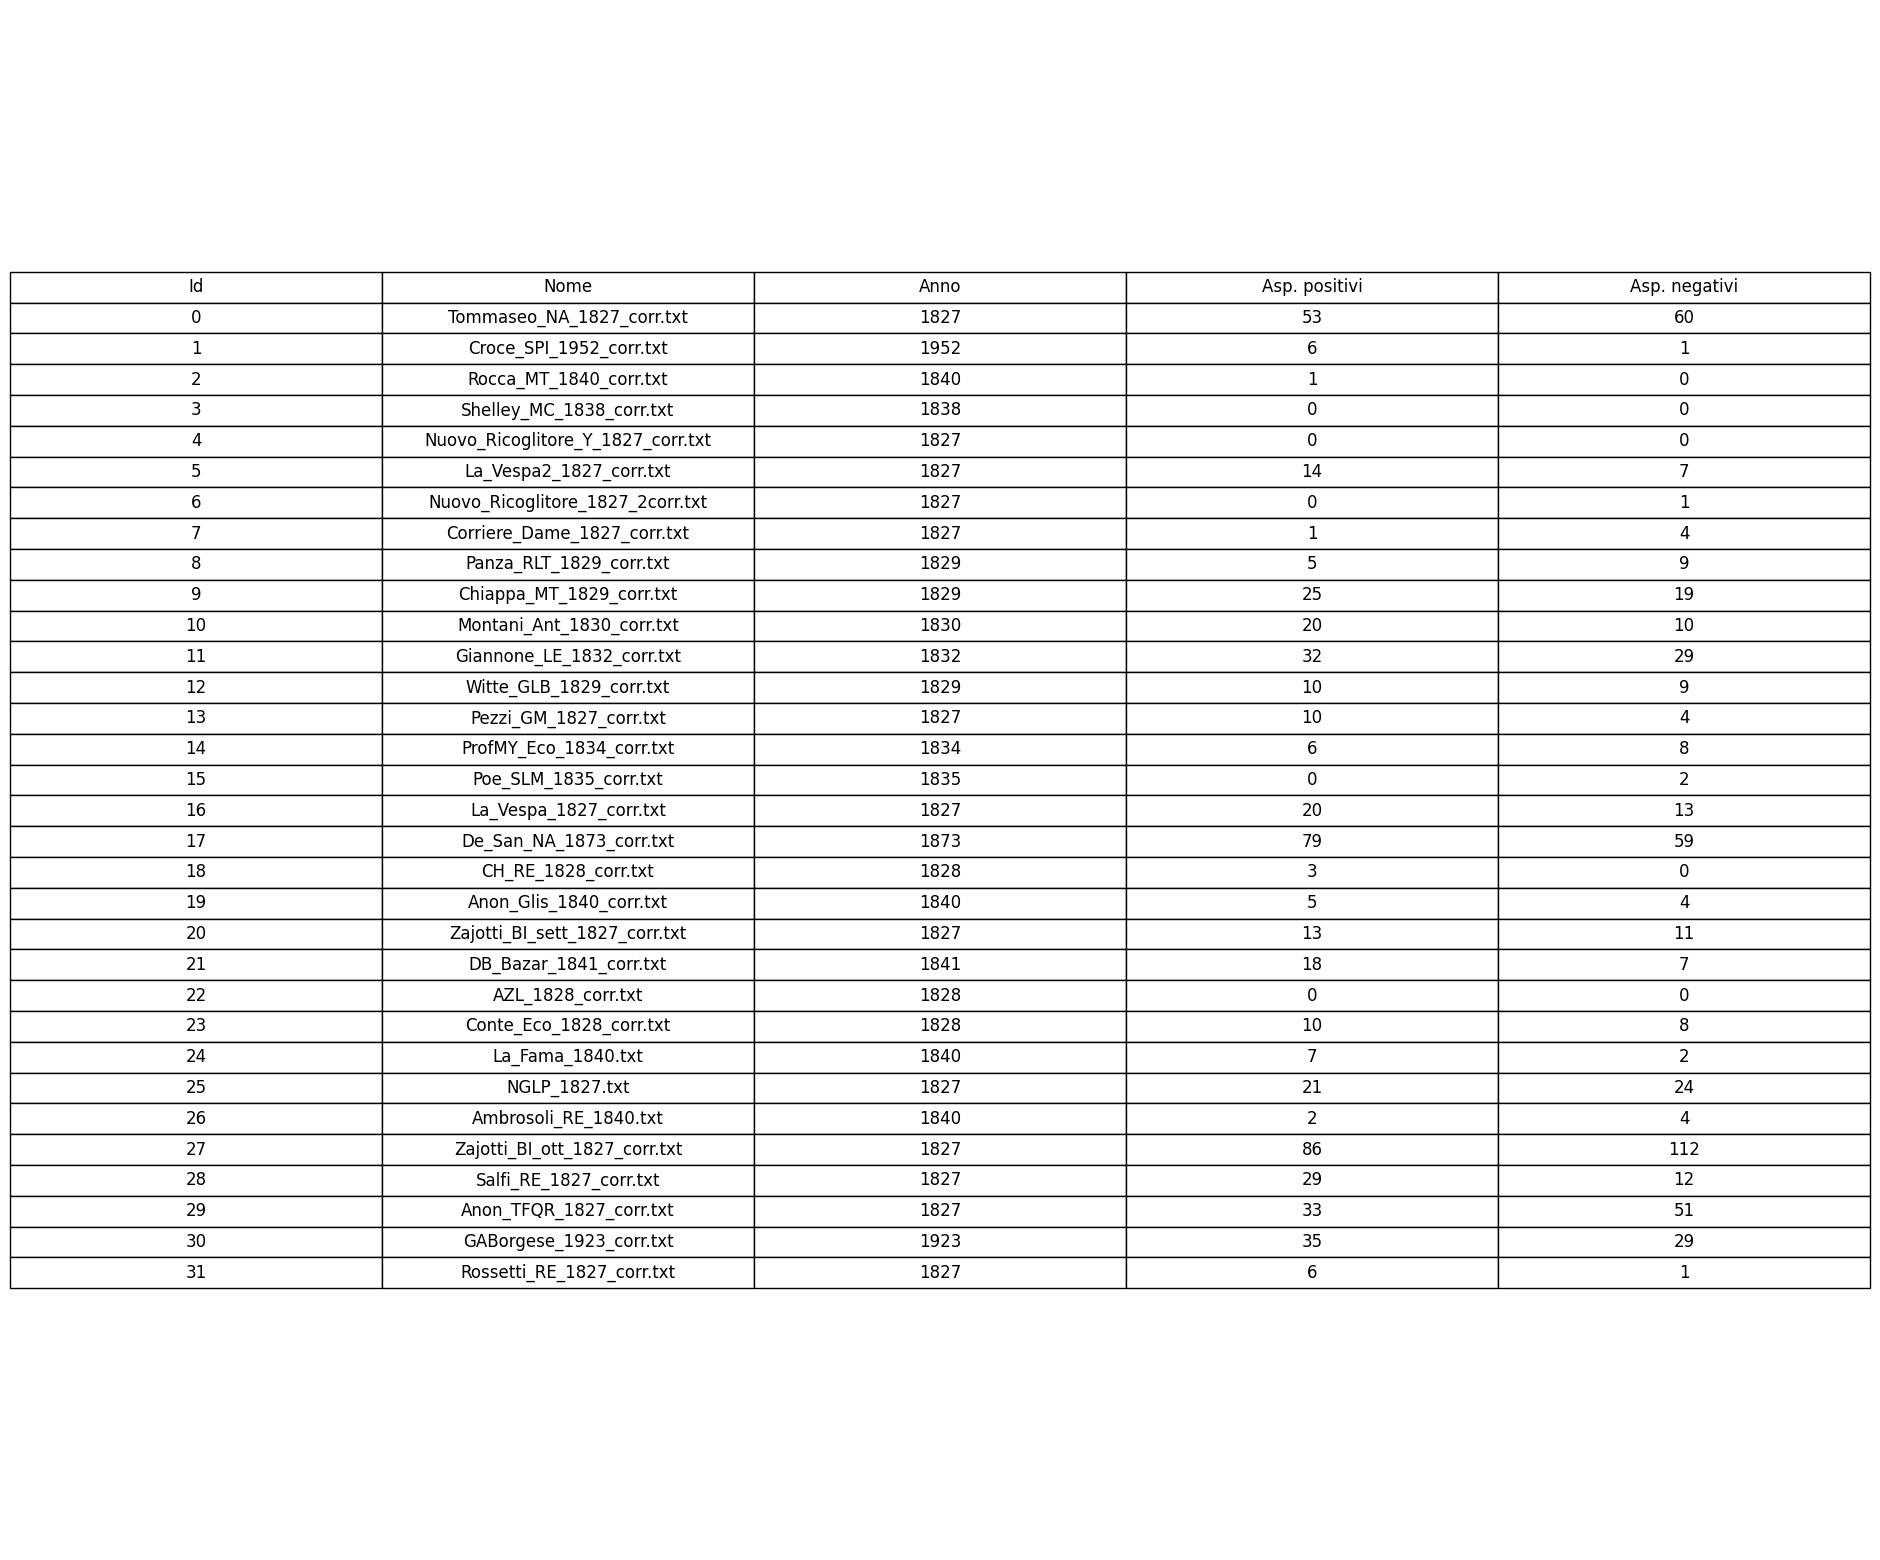

In [ ]:
fig, ax = plt.subplots(figsize=(20, 20))

#aggiunge la tabella
tabella = ax.table(cellText=[[review["id"], review["review_name"], review["year"], review["total_positive"], review["total_negative"]] for review in review_summary], colLabels=["Id", "Nome", "Anno", "Asp. positivi", "Asp. negativi"], loc='center')

#formattazione tabella
ax.axis('off')


tabella.auto_set_font_size(False)
tabella.set_fontsize(12)
tabella.scale(1.2, 1.2)



for i, col in enumerate(tabella.get_celld().keys()):
    if col[0] == 0:
        col_width = max(len(str(cell.get_text().get_text())) for cell in tabella.get_celld().values() if cell.get_text() is not None and cell.get_text().get_text())
        tabella.auto_set_column_width(col_width)

for i, key in enumerate(tabella.get_celld().keys()):
    row, col = key

    tabella.get_celld()[key].set_height(0.02)
    tabella.get_celld()[key].set_text_props(ha='center', va='center')
#salva immagine
plt.savefig("recensioni.png")

#mostra la tabella
plt.show()

**Grafico a dispersione per il sentiment generale delle recensioni**

3 [0.16931154 0.17360304]
4 [ 0.87298872 -0.42871083]


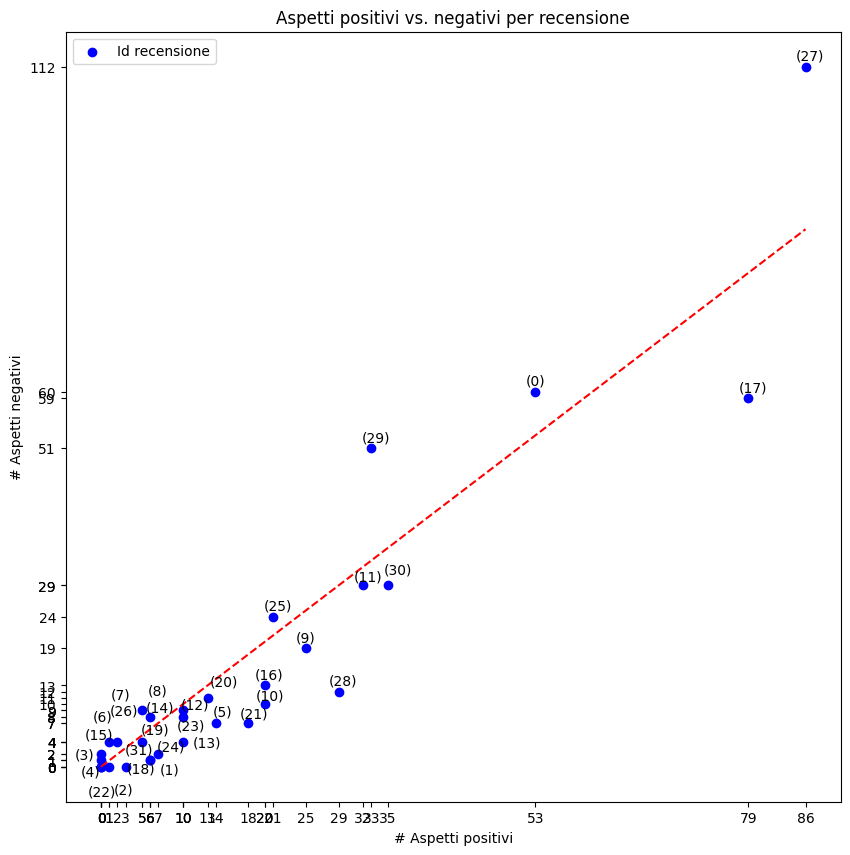

In [ ]:
from adjustText import adjust_text


positive_aspects = [review['total_positive'] for review in review_summary]
negative_aspects = [review['total_negative'] for review in review_summary]

texts = []
#crea grafico a dispersione
plt.figure(figsize=(10, 10))
plt.scatter(positive_aspects, negative_aspects, color='blue', label='Id recensione')

for i in range(len(review_summary)):
  texts.append(plt.text(positive_aspects[i], negative_aspects[i], f"({review_summary[i]['id']})", fontsize=10, ha='right', va='bottom', color='black'))
adjust_text(texts)

x = np.linspace(0, min(max(positive_aspects), max(negative_aspects)), 100)
y = x

plt.plot(x, y, color='red', linestyle='--')  #bisettrice

plt.xticks(positive_aspects, labels=[str(aspect) for aspect in positive_aspects])
plt.yticks(negative_aspects, labels=[str(aspect) for aspect in negative_aspects])


plt.xlabel("# Aspetti positivi")
plt.ylabel("# Aspetti negativi")
plt.title("Aspetti positivi vs. negativi per recensione")

plt.legend()

plt.savefig("Sentiment_complessivo.png")
plt.show()

**Grafici per l'evoluzione del sentiment negli anni 1827-1841**

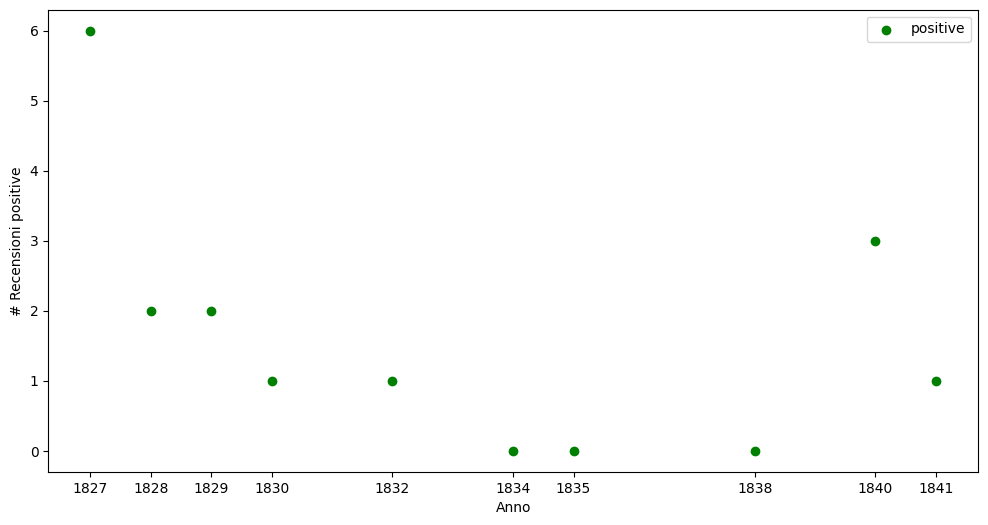

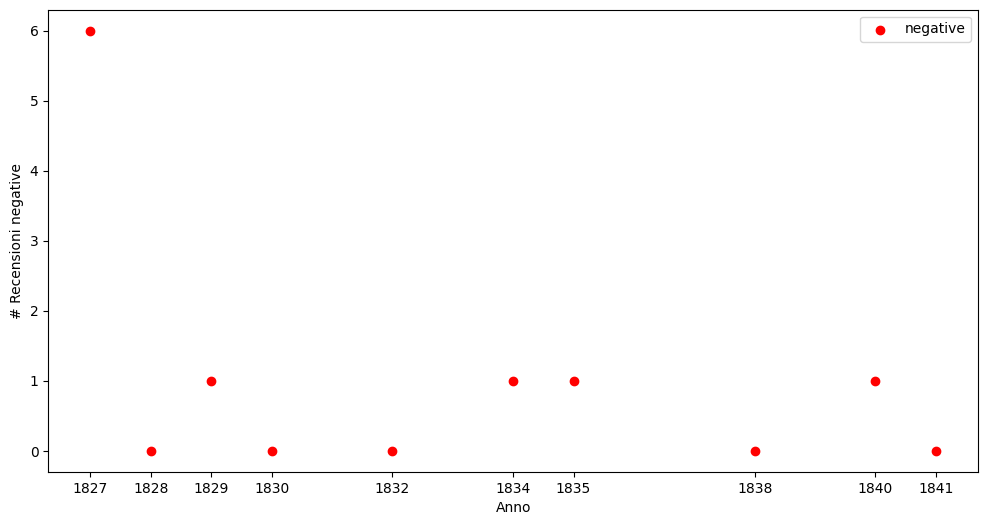

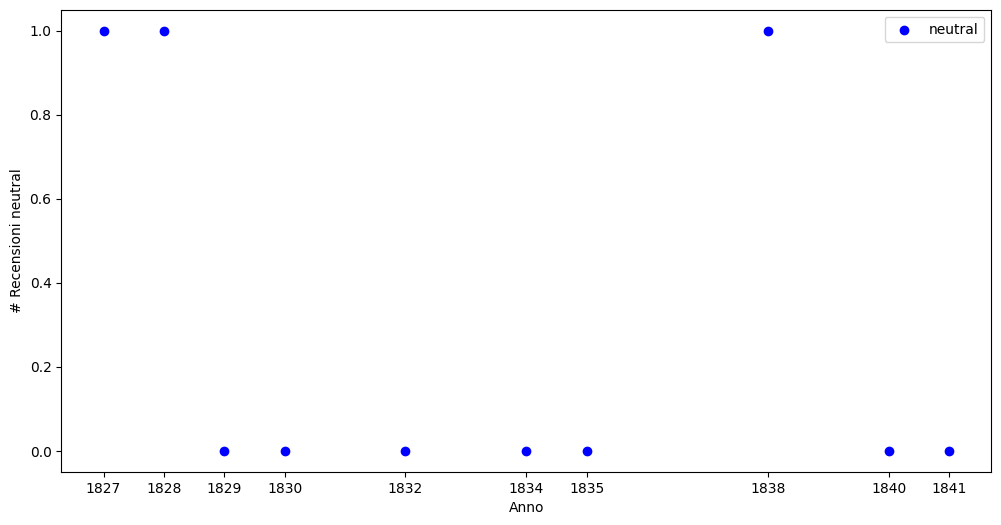

In [ ]:
review_summary = sorted(review_summary, key=lambda x: x['year'])  #ordina le recensioni per anno

years = []
sentiments = []
current_year = review_summary[0]['year']
current_sentiment = {"positive": 0, "negative": 0, "neutral": 0}
flag = False
#conta il numero di recensioni per ogni polarità presa in esame tenendo conto delle recensioni uscite tra il 1827 e il 1841
for review in review_summary:
  if review['year'] > 1841:
    flag = True
  if review['year'] != current_year:
    years.append(current_year)
    sentiments.append(current_sentiment)
    current_year = review['year']
    current_sentiment = {"positive": 0, "negative": 0, "neutral": 0}
    if flag:
      break
  current_sentiment[review['overall_sentiment']] += 1

#funzione che crea il grafico con i valori passati di sentiment e colore
def plot_overall_sentiment_per_year(sent, color):
  plt.figure(figsize=(12, 6))

  plt.scatter(years, [sentiment[sent] for sentiment in sentiments], color=color, label=sent)

  plt.xticks(years, labels = [str(year) for year in years])

  plt.legend()

  # Etichette degli assi
  plt.xlabel("Anno")
  plt.ylabel("# Recensioni "+ sent)

  plt.savefig("Year_" + sent + ".png")

  # Mostra il grafico
  plt.show()

#crea un grafico per ogni sentiment
plot_overall_sentiment_per_year("positive", "green")
plot_overall_sentiment_per_year("negative", "red")
plot_overall_sentiment_per_year("neutral", "blue")

**Tabella degli aspetti più frequenti dell'edizione Ventisettana, Quarantana e a livello globale**

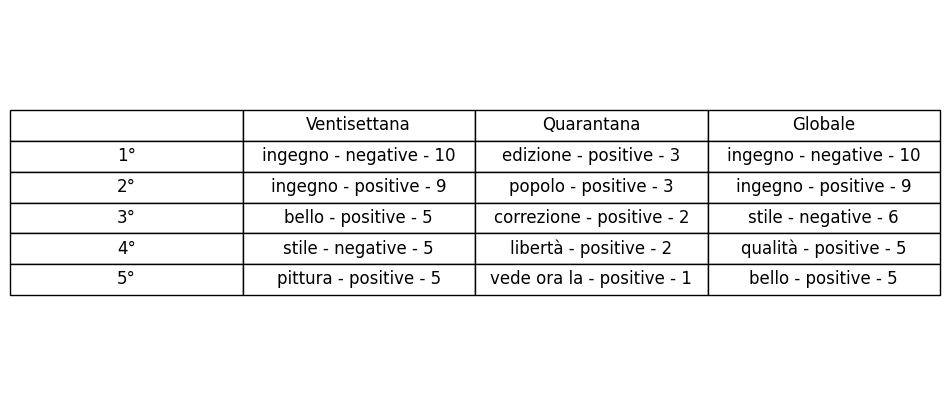

In [ ]:
from collections import defaultdict

#funzioni che permettono di estrarre i cinque aspetti più frequenti sfruttando hmap che mappa ogni aspetto nel numero di occorrenze

#a partire da hmap estrae i cinque aspetti più frequenti (il numero può essere modificato)
def five_aspects(hmap, num):
  best = [(("", ""), 0) for i in range(num)]
  for aspect in hmap:
    for i in range(num):
      if hmap[aspect] > best[i][1]:
        best.insert(i, (aspect, hmap[aspect]))
        best.pop()
        break
  return best

#verifica se l'anno delle recensioni è nel range e crea hmap
def get_aspects(min_year, max_year, num):
  hmap = defaultdict(int)
  for review in review_summary:
    if review["year"] < max_year and review["year"] >= min_year:
      for aspect in review["aspects"]:
        hmap[aspect] += 1
  return five_aspects(hmap, num)

ventisettana = get_aspects(1827, 1840, 5)
quarantana = get_aspects(1840, 1842, 5)
globale = get_aspects(1827, 1953, 5)


ventisettana = [ventisettana[i][0][0] + " - " + ventisettana[i][0][1] + " - " + f"{ventisettana[i][1]}" for i in range(len(ventisettana))]
quarantana = [quarantana[i][0][0] + " - " + quarantana[i][0][1] + " - " + f"{quarantana[i][1]}" for i in range(len(quarantana))]
globale = [globale[i][0][0] + " - " + globale[i][0][1] + " - " + f"{globale[i][1]}" for i in range(len(globale))]


rows = [[f"{i+1}°", ventisettana[i], quarantana[i], globale[i]] for i in range(5)]

fig, ax = plt.subplots(figsize=(10, 5))

#aggiunge la tabella
tabella = ax.table(cellText=rows, colLabels=["", "Ventisettana", "Quarantana", "Globale"], loc='center')

#formattazione
ax.axis('off')


tabella.auto_set_font_size(False)
tabella.set_fontsize(12)
tabella.scale(1.2, 1.2)



for i, col in enumerate(tabella.get_celld().keys()):
    if col[0] == 0:
        col_width = max(len(str(cell.get_text().get_text())) for cell in tabella.get_celld().values() if cell.get_text() is not None and cell.get_text().get_text())
        tabella.auto_set_column_width(col_width)

for i, key in enumerate(tabella.get_celld().keys()):
    row, col = key

    tabella.get_celld()[key].set_height(0.08)
    tabella.get_celld()[key].set_text_props(ha='center', va='center')
plt.savefig("chart.png")

plt.show()



**Tabella con valori medi per confronto delle recensioni della Ventisettana e della Quarantana**

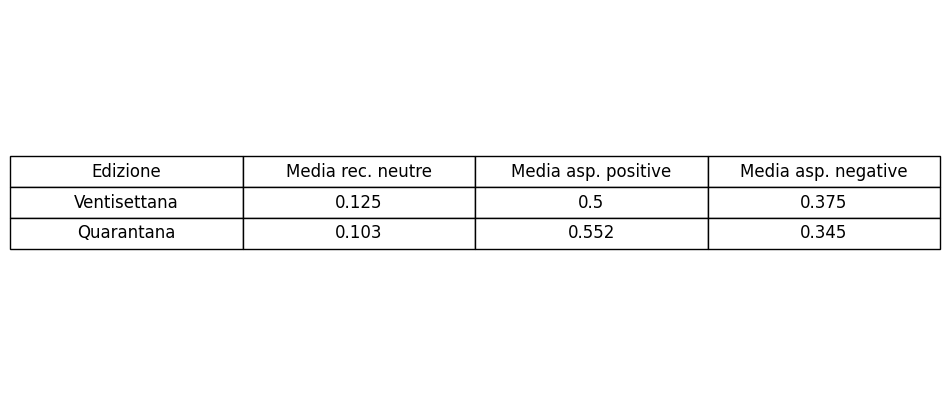

In [ ]:
#funzione che calcola il valore medio per ogni sentiment come totale delle recensioni con quel sentiment/totale recensioni dell'edizione
def mean_sent(sentiment):
    v_num, v_den, q_num, q_den = 0, 0, 0, 0
    for review in review_summary:
        if review["year"] < 1840:
            v_den += 1
            v_num += (1 if review["overall_sentiment"] == sentiment else 0)
        elif review["year"] < 1842:
            q_den += 1
            q_num += (1 if review["overall_sentiment"] == sentiment else 0)
    return v_num / v_den, q_num / q_den

venti_p, quara_p = mean_sent("positive")
venti_neg, quara_neg = mean_sent("negative")
venti_neu, quara_neu = mean_sent("neutral")

venti = ["Ventisettana", venti_neu, venti_p, venti_neg]
quara = ["Quarantana", quara_neu, quara_p, quara_neg]

values = [venti, quara]

fig, ax = plt.subplots(figsize=(10, 5))

tabella = ax.table(cellText=[[round(value[i], 3) if isinstance(value[i], float) else value[i] for i in range(len(value))] for value in values], colLabels=["Edizione", "Media rec. neutre", "Media asp. positive", "Media asp. negative"], loc='center')

#formattazione
ax.axis('off')


tabella.auto_set_font_size(False)
tabella.set_fontsize(12)
tabella.scale(1.2, 1.2)



for i, col in enumerate(tabella.get_celld().keys()):
    if col[0] == 0:
        col_width = max(len(str(cell.get_text().get_text())) for cell in tabella.get_celld().values() if cell.get_text() is not None and cell.get_text().get_text())
        tabella.auto_set_column_width(col_width)

for i, key in enumerate(tabella.get_celld().keys()):
    row, col = key

    tabella.get_celld()[key].set_height(0.08)
    tabella.get_celld()[key].set_text_props(ha='center', va='center')
plt.savefig("media.png")

plt.show()
